In [27]:
import numpy as np
import pandas as pd
import sklearn
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report,accuracy_score
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
from pylab import rcParams
rcParams["figure.figsize"] = 14,8
RANDOM_SEED = 42
LABELS = ["Normal" , "Fraud"]
import warnings
warnings.filterwarnings("ignore")

In [28]:
df = pd.read_csv("creditcard.csv")
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

# EDA

In [30]:
df.isnull().sum()

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

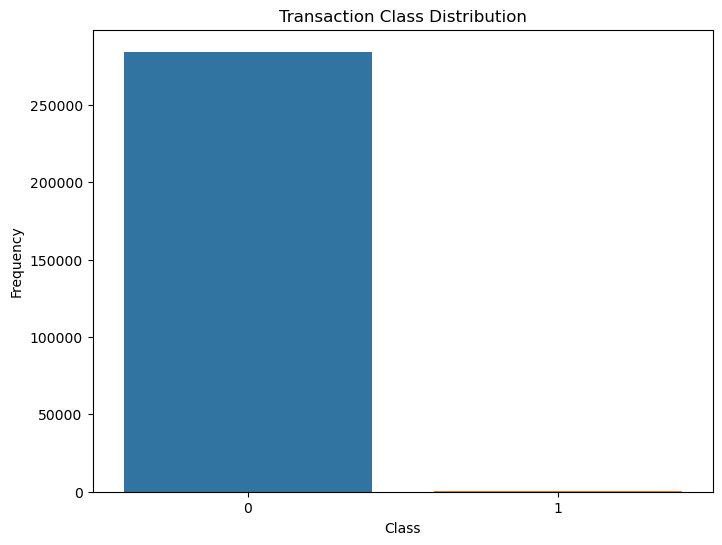

In [31]:
import seaborn as sns
count_classes = df['Class'].value_counts()
plt.figure(figsize=(8, 6))
sns.countplot(x='Class', data=df, order=count_classes.index)
plt.title('Transaction Class Distribution')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.show()


In [32]:
# getting fraud and normal data set
fraud = df[df["Class"]==1]
normal = df[df["Class"]==0]

In [33]:
print(fraud.shape,normal.shape)

(492, 31) (284315, 31)


In [34]:
# we need to analyze more amount of information from the transaction data
# how different are the amount of mony used in different transaction classes?

fraud.Amount.describe()

count     492.000000
mean      122.211321
std       256.683288
min         0.000000
25%         1.000000
50%         9.250000
75%       105.890000
max      2125.870000
Name: Amount, dtype: float64

In [35]:
normal.Amount.describe()

count    284315.000000
mean         88.291022
std         250.105092
min           0.000000
25%           5.650000
50%          22.000000
75%          77.050000
max       25691.160000
Name: Amount, dtype: float64

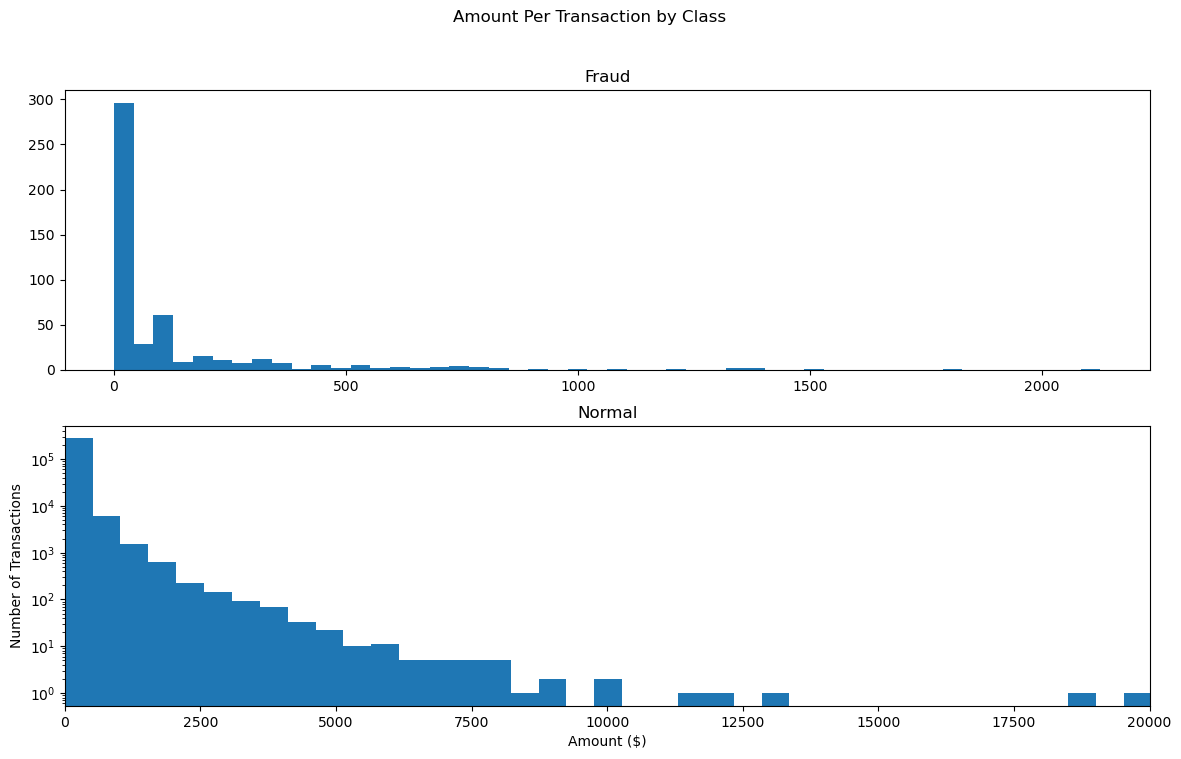

In [38]:
fig,(ax1,ax2)= plt.subplots(2,1)
plt.suptitle("Amount Per Transaction by Class")
ax1.hist(fraud.Amount,bins = 50)
ax1.set_title("Fraud")
ax2.hist(normal.Amount,bins = 50)
ax2.set_title("Normal")
plt.xlabel("Amount ($)")
plt.ylabel("Number of Transactions")
plt.xlim((0,20000))
plt.yscale("log")
plt.show()



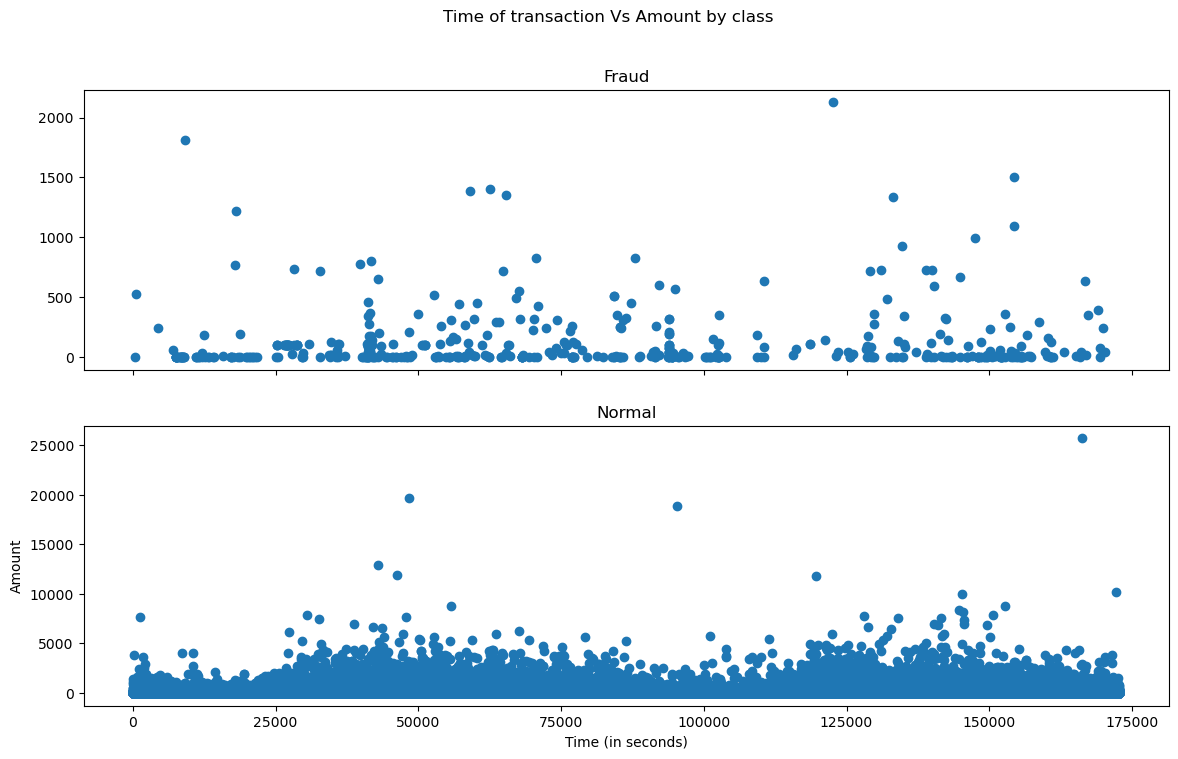

In [41]:
# We will check do fradulent transactions occur more often during certain time frame? Let us find out with a visual representation

fig,(ax1,ax2) = plt.subplots(2,1,sharex = True)
fig.suptitle("Time of transaction Vs Amount by class")
ax1.scatter(fraud.Time,fraud.Amount)
ax1.set_title("Fraud")
ax2.scatter(normal.Time,normal.Amount)
ax2.set_title("Normal")
plt.xlabel("Time (in seconds)")
plt.ylabel("Amount")
plt.show()

In [42]:
# Take some sample of the data 
df1 = df.sample(frac = 0.1,random_state=1)
df1.shape

(28481, 31)

In [43]:
df.shape

(284807, 31)

In [44]:
# Determine the number of fraud and valid transactions in the data set
Fraud = df1[df1["Class"]==1]
Valid = df1[df1["Class"]==0]
outlier_fraction = len(Fraud)/float(len(Valid))

In [46]:
print(outlier_fraction)
print("Fraud Cases : {}".format(len(Fraud)))
print("Valid Cases : {}".format(len(Valid)))

0.0017234102419808666
Fraud Cases : 49
Valid Cases : 28432


<Axes: >

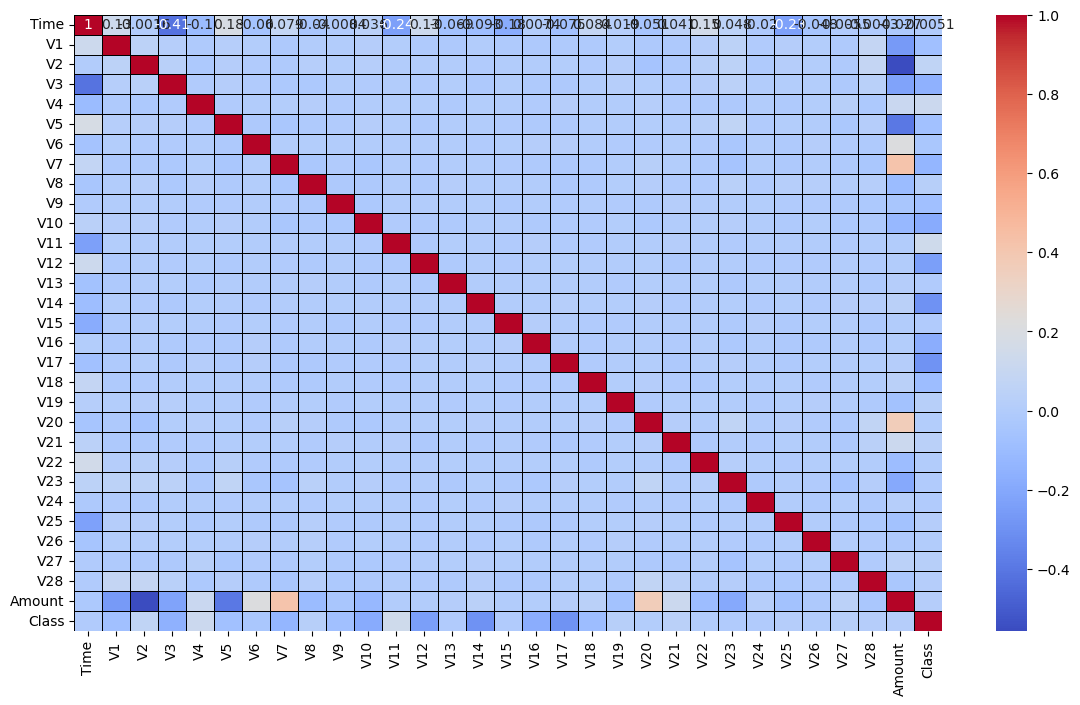

In [47]:
sns.heatmap(data = df1.corr(),annot = True,cmap = "coolwarm",linewidths=0.5,linecolor="black")

In [48]:
#Create independent and Dependent Features
columns = df1.columns.tolist()
# Filter the columns to remove data we do not want 
columns = [c for c in columns if c not in ["Class"]]
# Store the variable we are predicting 
target = "Class"
# Define a random state 
state = np.random.RandomState(42)
X = df1[columns]
Y = df1[target]
X_outliers = state.uniform(low=0, high=1, size=(X.shape[0], X.shape[1]))
# Print the shapes of X & Y
print(X.shape)
print(Y.shape)

(28481, 30)
(28481,)


In [51]:
##Define the outlier detection methods

classifiers = {
    "Isolation Forest":IsolationForest(n_estimators=100, max_samples=len(X), 
                                       contamination=outlier_fraction,random_state=state, verbose=0),
    "Local Outlier Factor":LocalOutlierFactor(n_neighbors=20, algorithm='auto', 
                                              leaf_size=30, metric='minkowski',
                                              p=2, metric_params=None, contamination=outlier_fraction),
    "Support Vector Machine":OneClassSVM(kernel='rbf', degree=3, gamma=0.1,nu=0.05, 
                                         max_iter=-1)
   
}

In [52]:
type(classifiers)

dict

In [53]:
n_outliers = len(Fraud)
for i, (clf_name,clf) in enumerate(classifiers.items()):
    #Fit the data and tag outliers
    if clf_name == "Local Outlier Factor":
        y_pred = clf.fit_predict(X)
        scores_prediction = clf.negative_outlier_factor_
    elif clf_name == "Support Vector Machine":
        clf.fit(X)
        y_pred = clf.predict(X)
    else:    
        clf.fit(X)
        scores_prediction = clf.decision_function(X)
        y_pred = clf.predict(X)
    #Reshape the prediction values to 0 for Valid transactions , 1 for Fraud transactions
    y_pred[y_pred == 1] = 0
    y_pred[y_pred == -1] = 1
    n_errors = (y_pred != Y).sum()
    # Run Classification Metrics
    print("{}: {}".format(clf_name,n_errors))
    print("Accuracy Score :")
    print(accuracy_score(Y,y_pred))
    print("Classification Report :")
    print(classification_report(Y,y_pred))

Isolation Forest: 73
Accuracy Score :
0.9974368877497279
Classification Report :
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     28432
           1       0.26      0.27      0.26        49

    accuracy                           1.00     28481
   macro avg       0.63      0.63      0.63     28481
weighted avg       1.00      1.00      1.00     28481

Local Outlier Factor: 97
Accuracy Score :
0.9965942207085425
Classification Report :
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     28432
           1       0.02      0.02      0.02        49

    accuracy                           1.00     28481
   macro avg       0.51      0.51      0.51     28481
weighted avg       1.00      1.00      1.00     28481

Support Vector Machine: 8515
Accuracy Score :
0.7010287560127805
Classification Report :
              precision    recall  f1-score   support

           0       1.00      0.70   

# Observations

The Isolation Forest detected 73 anomalies, while the Local Outlier Factor (LOF) detected 97, and the Support Vector Machine (SVM) identified 8,516 errors. Isolation Forest achieved an accuracy of 99.74%, slightly higher than LOF at 99.65%, and significantly better than SVM at 70.09%.

When comparing the error precision and recall across the three models, the Isolation Forest demonstrated superior performance. It detected approximately 27% of fraud cases, compared to LOF’s detection rate of just 2% and SVM’s detection rate of 0%.

Overall, the Isolation Forest method was much more effective, identifying around 30% of fraud cases. Accuracy could potentially be improved by increasing the sample size or by using deep learning algorithms, although this would come at a higher computational cost. More advanced anomaly detection models could also enhance the identification of fraudulent cases.